In [11]:

import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt


In [6]:
from for_importing import X_cleaned,y

In [7]:

# Calculate correlations
X=X_cleaned

correlations = X_cleaned.corrwith(y,axis=0)

sorted_correlations = correlations.abs().sort_values(ascending=False) # sort by absolute value to see most correlated X values

print("Feature correlations with target:")
print(sorted_correlations)

Feature correlations with target:
PctKids2Par            0.738424
PctIlleg               0.737957
PctFam2Par             0.706667
racePctWhite           0.684770
PctYoungKids2Par       0.666059
                         ...   
racePctAsian           0.037622
householdsize          0.034923
PctWorkMomYoungKids    0.022535
PctVacMore6Mos         0.021283
PctSameState85         0.019459
Length: 99, dtype: float64


In [8]:
r_threshold=0.5

correlated_features=correlations[correlations.abs()>r_threshold].index
x_corr=X[correlated_features]

print(f'After dropping columns with less than {r_threshold} pearson correlation coefficient, we now have {x_corr.shape[1]} columns')

After dropping columns with less than 0.5 pearson correlation coefficient, we now have 15 columns


In [9]:
print(sorted_correlations[:15])

PctKids2Par         0.738424
PctIlleg            0.737957
PctFam2Par          0.706667
racePctWhite        0.684770
PctYoungKids2Par    0.666059
PctTeen2Par         0.661582
racepctblack        0.631264
pctWInvInc          0.576324
pctWPubAsst         0.574665
FemalePctDiv        0.556032
TotalPctDiv         0.552777
PctPersOwnOccup     0.525491
MalePctDivorce      0.525407
PctPopUnderPov      0.521877
PctUnemployed       0.504235
dtype: float64


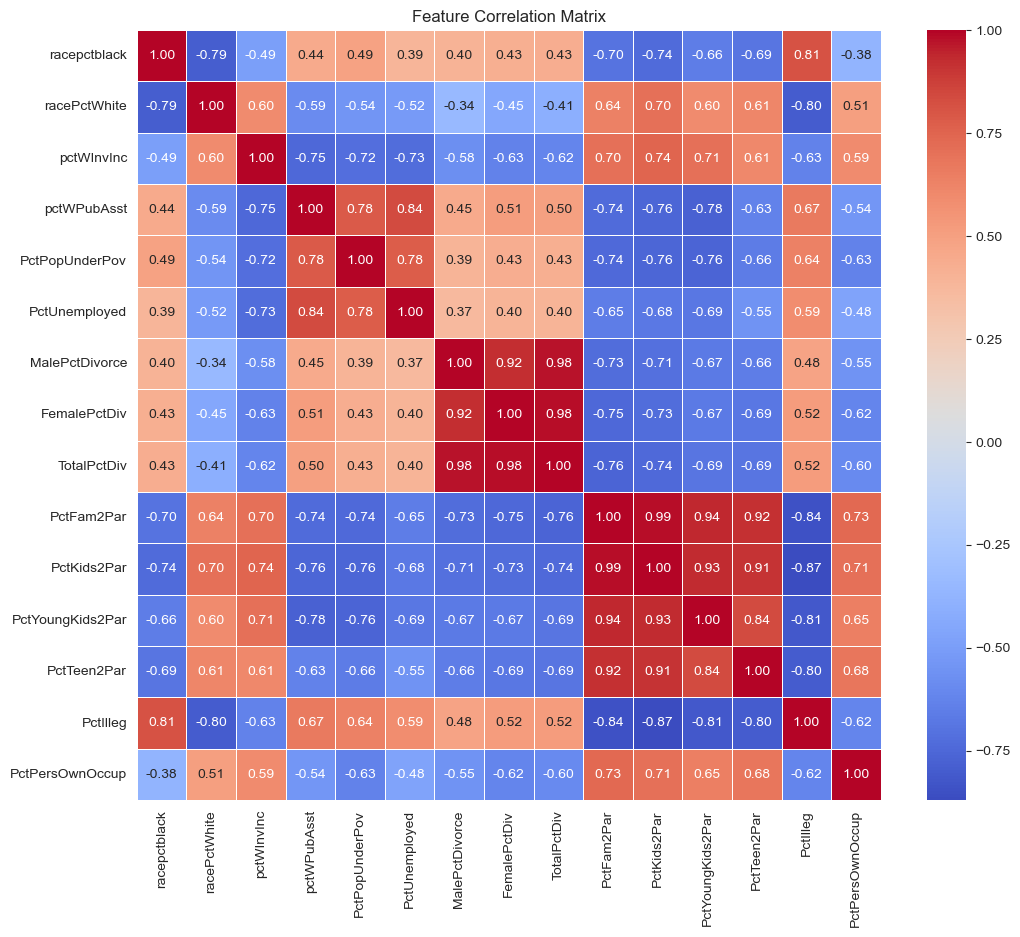

In [12]:
corr_matrix = x_corr.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title("Feature Correlation Matrix")
plt.show()

This correlation matrix shows us that of the remaining features, there are a few pairs of features that are highly correlated and thus redundant and removable. The high correlation is represented by either the deep red (correlation close to 1) or deep blue (correlation close to -1). For example, the percent of total people divorced, the percent of males divorced, and the percent of females divorced are unsurprisingly highly correlated, each with a correlation of over 0.90 with one another. As such, I am going to remove percent of male divorcees and percent of female divorcees. Another example is that the percentage of families headed by 2 parents, the percentage of kids with 2 parents, the percentage of young kids (under 4) with 2 parents, and the percentage of teens with 2 parents all have correlations over .90 with one another.


In [13]:


x_features=x_corr.drop(['FemalePctDiv','MalePctDivorce','PctFam2Par','PctYoungKids2Par','PctTeen2Par','PctIlleg','PctUnemployed'],axis=1)



In [14]:
print(x_features.corrwith(y,axis=0).sort_values())

PctKids2Par       -0.738424
racePctWhite      -0.684770
pctWInvInc        -0.576324
PctPersOwnOccup   -0.525491
PctPopUnderPov     0.521877
TotalPctDiv        0.552777
pctWPubAsst        0.574665
racepctblack       0.631264
dtype: float64


In [15]:
print(x_features.columns)

Index(['racepctblack', 'racePctWhite', 'pctWInvInc', 'pctWPubAsst',
       'PctPopUnderPov', 'TotalPctDiv', 'PctKids2Par', 'PctPersOwnOccup'],
      dtype='object')


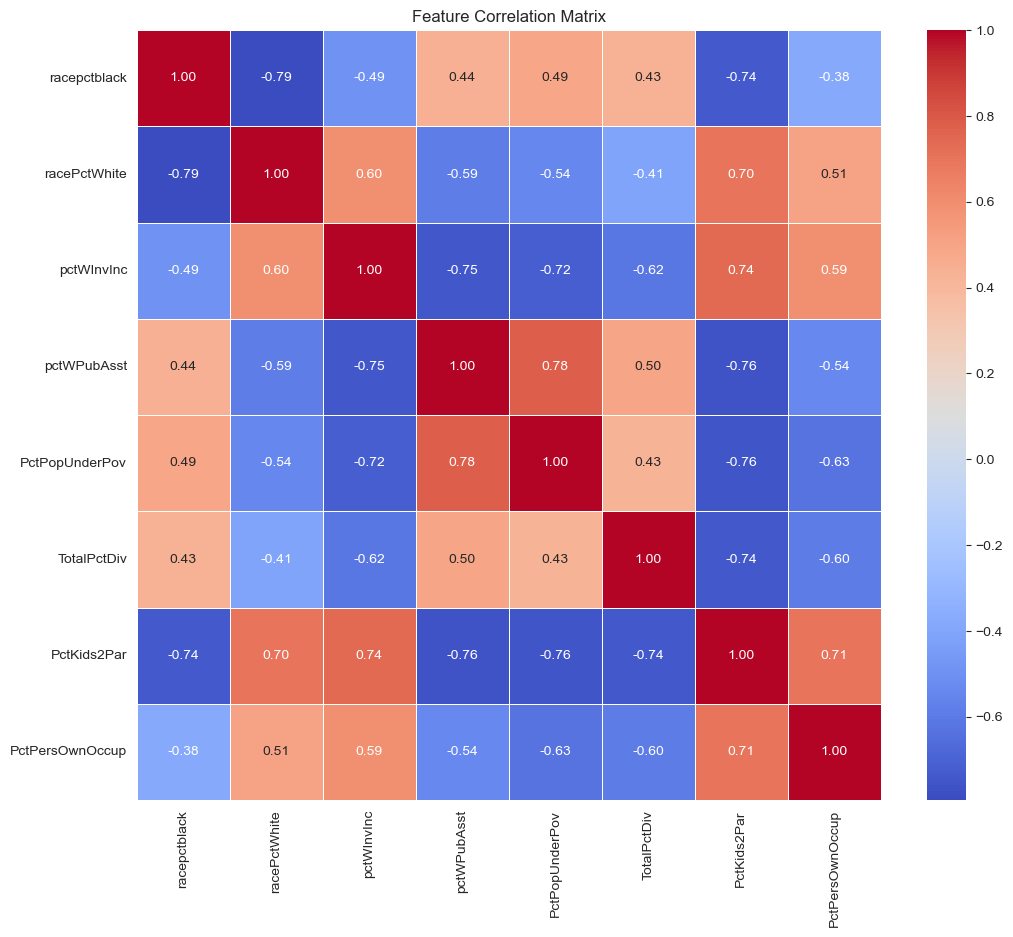

In [16]:
corr_matrix = x_features.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title("Feature Correlation Matrix")
plt.show()


Now there are no two features that are correlated greater than the absolute value of 0.8. The lasso regularizer in linear regression will further help with feature selection.

**LINEAR REGRESSION**

The best r-squared value using lasso is 0.6427, which is when alpha = 6.7e-05


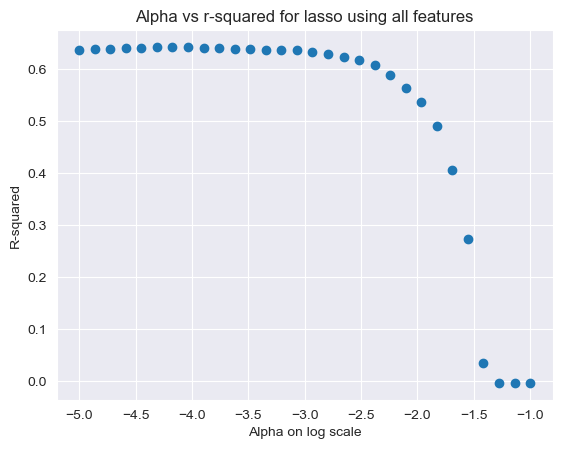

In [17]:
#All features, initial alpha testing

xftr,xfts,yftr,yfts=train_test_split(X,y,test_size=0.2,random_state=22) #split data using all 99 features

lasso_range=np.logspace(start=-5,stop=-1,num=30)
rsq_lasso=[]


for alpha in lasso_range:
  model=Lasso(alpha=alpha,max_iter=1000,tol=.01)
  cv=cross_validate(estimator=model,X=xftr,y=yftr,scoring='r2',return_estimator=True)
  rsq=np.mean(cv['test_score'])
  rsq_lasso.append(rsq)
  coefficients = [estimator.coef_ for estimator in cv['estimator']]



best_rsq=max(rsq_lasso)
best_rsq_arg=np.argmax(rsq_lasso)
best_alpha=lasso_range[best_rsq_arg]
print(f'The best r-squared value using lasso is {round(best_rsq,4)}, which is when alpha = {round(best_alpha,6)}')
plt.scatter(np.log10(lasso_range),rsq_lasso)
plt.xlabel('Alpha on log scale')
plt.ylabel('R-squared')
plt.title('Alpha vs r-squared for lasso using all features')
plt.show()


Since the best r-sq is when alpha is $6.7*10^{-5}$ ( which is between to $10^{-4}$ and $10^{-5}$), we are going to try to further optimize the alpha, running 50 iterations with alpha between $10^{-3}$ and $10^ {-5}$.

The best r-squared value using lasso is 0.6427, which is when alpha = 6.6e-05


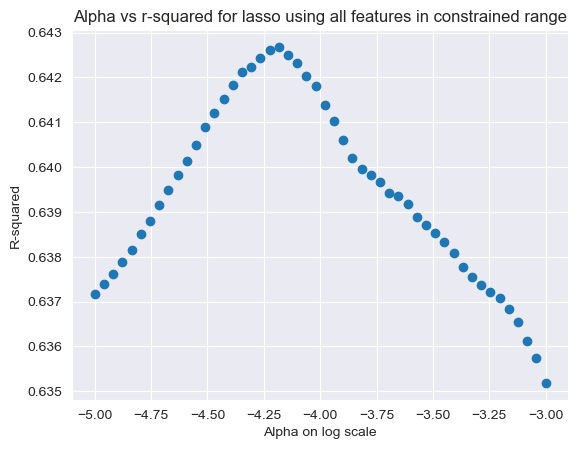

The optimal weights are [-0.0356  0.0181  0.1461 -0.0608 -0.0018  0.002   0.0188 -0.2566 -0.0083
  0.0022 -0.0921  0.0282  0.     -0.157   0.0289 -0.1455  0.0541 -0.064
 -0.0839  0.0186  0.0018 -0.1647 -0.0276 -0.0368  0.0064  0.0421 -0.0508
 -0.1336 -0.0714  0.      0.029  -0.021   0.117  -0.0522 -0.0071  0.0681
  0.0921  0.1732  0.1353 -0.0979  0.     -0.0066 -0.0287 -0.3347 -0.001
  0.0107  0.0188 -0.1466 -0.0302  0.1474 -0.1063  0.0176  0.0004 -0.0008
  0.0148 -0.015   0.0017  0.0097  0.0251 -0.0338 -0.0578 -0.0934 -0.0385
  0.3942 -0.101  -0.1226 -0.0846  0.2032  0.0987  0.0213  0.2515 -0.0282
  0.      0.0413 -0.0708 -0.0083  0.0141 -0.0101 -0.0444  0.      0.0326
 -0.1983  0.     -0.0262  0.2744  0.0601 -0.0388 -0.0654  0.0785  0.2222
  0.0188  0.007   0.0032  0.0092  0.0208  0.0054 -0.0034 -0.0347  0.0331]


In [18]:
#All features, optimizing alpha in constrained range


lasso_range=np.logspace(start=-5,stop=-3,num=50)
rsq_lasso=[]
lasso_matrices=[]
biases=[]

for alpha in lasso_range:
  model=Lasso(alpha=alpha,max_iter=1000,tol=.01)
  cv=cross_validate(estimator=model,X=xftr,y=yftr,scoring='r2',return_estimator=True)
  rsq=np.mean(cv['test_score'])
  rsq_lasso.append(rsq)
  coefficients = [estimator.coef_ for estimator in cv['estimator']]
  average_coefficients = np.mean(coefficients, axis=0)
  lasso_matrices.append(average_coefficients)
  bias = np.mean([estimator.intercept_ for estimator in cv['estimator']])
  biases.append(bias)


best_rsq=max(rsq_lasso)
best_rsq_arg=np.argmax(rsq_lasso)
best_alpha=lasso_range[best_rsq_arg]
best_bias=biases[best_rsq_arg]
best_weights=lasso_matrices[best_rsq_arg]
print(f'The best r-squared value using lasso is {round(best_rsq,4)}, which is when alpha = {round(best_alpha,6)}')
plt.scatter(np.log10(lasso_range),rsq_lasso)
plt.xlabel('Alpha on log scale')
plt.ylabel('R-squared')
plt.title('Alpha vs r-squared for lasso using all features in constrained range')
plt.show()
print(f'The optimal weights are {np.round(best_weights,4)}')

<StemContainer object of 3 artists>

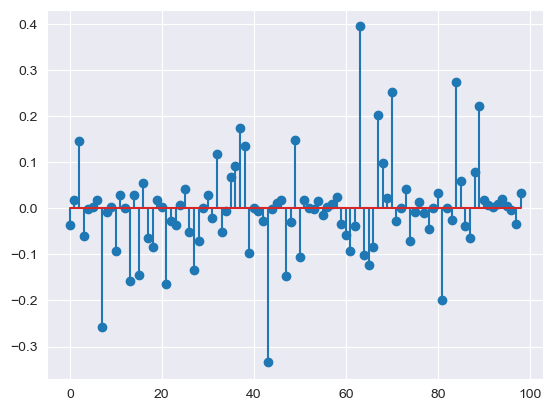

In [20]:
plt.stem(best_weights)



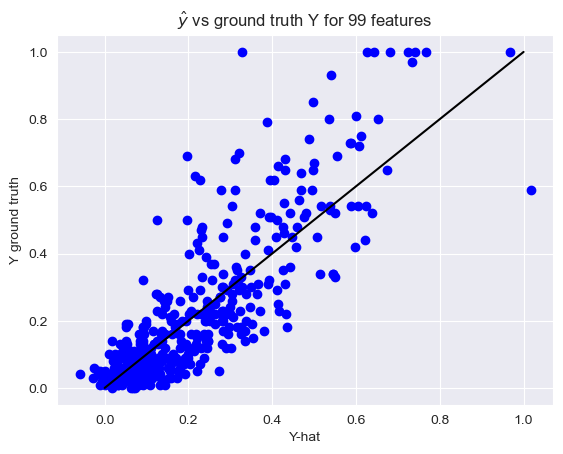

R-squared: 0.6893


In [21]:
#testing data with all features

model=Lasso(alpha=best_alpha,max_iter=1000,tol=.01)
model.fit(xftr,yftr)
yhat_all=model.predict(xfts)

x_vals=np.linspace(0,1,100)
y_vals=x_vals
ytr_pred=model.predict(xftr)

# Plot
plt.scatter(yhat_all, yfts,color='b')
plt.plot(x_vals,y_vals,color='black')
plt.xlabel("Y-hat")
plt.ylabel("Y ground truth")
plt.title(r'$\hat{y}$ vs ground truth Y for 99 features')
plt.show()

r2 = r2_score(yfts, yhat_all)
print(f"R-squared: {r2:.4f}")


The best r-squared value using lasso is 0.5915, which is when alpha = 0.0003


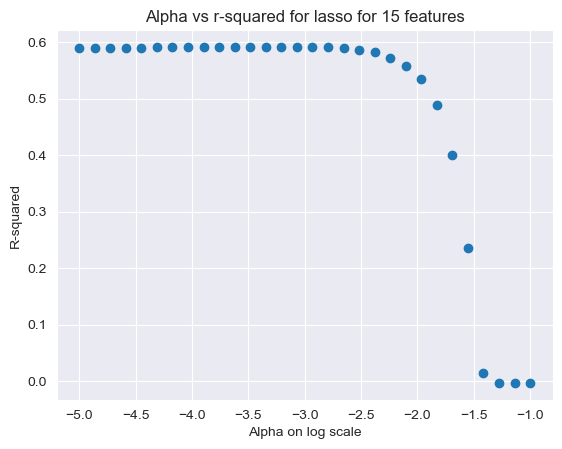

In [22]:

columns_8=['racepctblack', 'racePctWhite', 'pctWInvInc', 'pctWPubAsst',
       'PctPopUnderPov', 'TotalPctDiv', 'PctKids2Par', 'PctPersOwnOccup']

xtr,xts=xftr[columns_8], xfts[columns_8]


lasso_range=np.logspace(start=-5,stop=-1,num=30)
rsq_lasso=[]


for alpha in lasso_range:
  model=Lasso(alpha=alpha,max_iter=1000,tol=.01)
  cv=cross_validate(estimator=model,X=xtr,y=yftr,scoring='r2',return_estimator=True)
  rsq=np.mean(cv['test_score'])
  rsq_lasso.append(rsq)
  coefficients = [estimator.coef_ for estimator in cv['estimator']]
  bias = np.mean([estimator.intercept_ for estimator in cv['estimator']])
  biases.append(bias)


best_rsq=max(rsq_lasso)
best_rsq_arg=np.argmax(rsq_lasso)
best_alpha=lasso_range[best_rsq_arg]
print(f'The best r-squared value using lasso is {round(best_rsq,4)}, which is when alpha = {round(best_alpha,4)}')
plt.scatter(np.log10(lasso_range),rsq_lasso)
plt.xlabel('Alpha on log scale')
plt.ylabel('R-squared')
plt.title('Alpha vs r-squared for lasso for 15 features')
plt.show()


The best r-squared value using lasso is 0.5915, which is when alpha = 0.0003


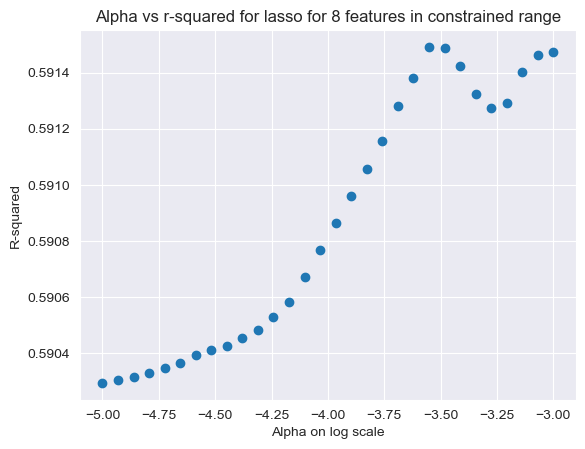

The optimal weights are [ 0.0006 -0.3274  0.      0.0089 -0.0497  0.1359 -0.4801 -0.0149]


In [23]:
lasso_range=np.logspace(start=-5,stop=-3,num=30) #8 features, further optimizing alpha in constrained range
rsq_lasso=[]
lasso_matrices=[]
biases=[]
for alpha in lasso_range:
  model=Lasso(alpha=alpha,max_iter=1000,tol=.01)
  cv=cross_validate(estimator=model,X=xtr,y=yftr,scoring='r2',return_estimator=True)
  rsq=np.mean(cv['test_score'])
  rsq_lasso.append(rsq)
  coefficients = [estimator.coef_ for estimator in cv['estimator']]
  average_coefficients = np.mean(coefficients, axis=0)
  lasso_matrices.append(average_coefficients)
  bias = np.mean([estimator.intercept_ for estimator in cv['estimator']])
  biases.append(bias)


best_rsq=max(rsq_lasso)
best_rsq_arg=np.argmax(rsq_lasso)
best_alpha=lasso_range[best_rsq_arg]
best_bias=biases[best_rsq_arg]
best_weights=lasso_matrices[best_rsq_arg]
print(f'The best r-squared value using lasso is {round(best_rsq,4)}, which is when alpha = {round(best_alpha,4)}')
plt.scatter(np.log10(lasso_range),rsq_lasso)
plt.xlabel('Alpha on log scale')
plt.ylabel('R-squared')
plt.title('Alpha vs r-squared for lasso for 8 features in constrained range')
plt.show()
print(f'The optimal weights are {np.round(best_weights,4)}')

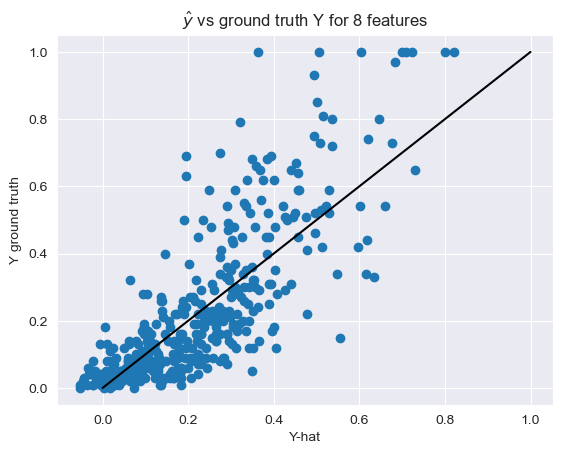

R-squared: 0.6332


In [24]:
model=Lasso(alpha=best_alpha,max_iter=1000,tol=.01)
model.fit(xtr,yftr)
yhat_8=model.predict(xts)

x_vals=np.linspace(0,1,100)
y_vals=x_vals


# Plot
plt.scatter(yhat_8, yfts)
plt.plot(x_vals,y_vals,color='black')
plt.xlabel("Y-hat")
plt.ylabel("Y ground truth")
plt.title(r'$\hat{y}$ vs ground truth Y for 8 features')
plt.show()

r2 = r2_score(yfts, yhat_8)
print(f"R-squared: {r2:.4f}")

([<matplotlib.axis.XTick at 0x133f212b0>,
 [Text(0, 0, 'racepctblack'),
  Text(1, 0, 'racePctWhite'),
  Text(2, 0, 'pctWInvInc'),
  Text(3, 0, 'pctWPubAsst'),
  Text(4, 0, 'PctPopUnderPov'),
  Text(5, 0, 'TotalPctDiv'),
  Text(6, 0, 'PctKids2Par'),
  Text(7, 0, 'PctPersOwnOccup')])

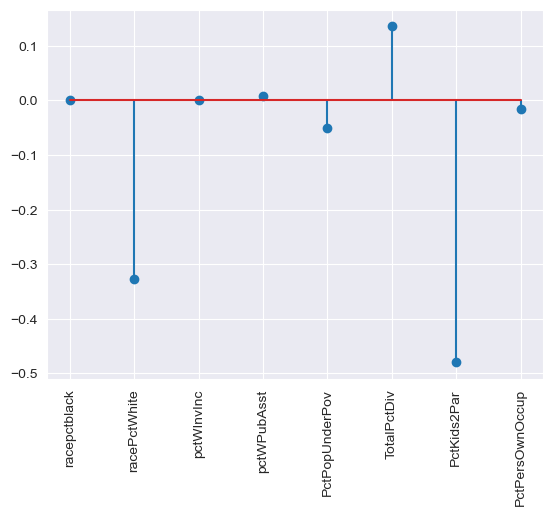

In [25]:
plt.stem(best_weights)

plt.xticks(ticks=range(len(x_features.columns)), labels=x_features.columns, rotation=90)


When examining the weights above, I noticed that there are two weights, the second (-.3077) and the second to last (-.5265), have a far greater magnitude than the other weights. These weights correspond to the percent of caucasian people and the percentage of kids that live with 2 parents, respectively. As such, I am going to test whether simplifying the model to just 2 features, will cause the r-square value to decrease much, which is currently at .6065 with 8 features.

The best r-squared value using lasso is 0.5857, which is when alpha = 0.0


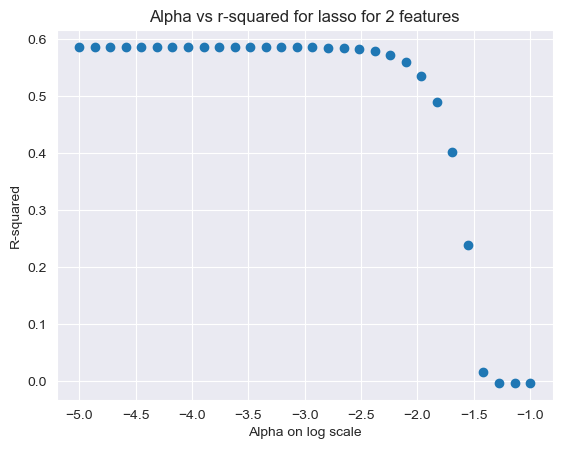

In [26]:
two_weights=[best_weights[1],best_weights[-2]]
two_features=['racePctWhite','PctKids2Par']

xtr2,xts2 = xftr[two_features],xfts[two_features]

lasso_range=np.logspace(start=-5,stop=-1,num=30)
rsq_lasso=[]


for alpha in lasso_range:
  model=Lasso(alpha=alpha,max_iter=1000,tol=.01)
  cv=cross_validate(estimator=model,X=xtr2,y=yftr,scoring='r2',return_estimator=True)
  rsq=np.mean(cv['test_score'])
  rsq_lasso.append(rsq)
  coefficients = [estimator.coef_ for estimator in cv['estimator']]
  bias = np.mean([estimator.intercept_ for estimator in cv['estimator']])
  biases.append(bias)


best_rsq=max(rsq_lasso)
best_rsq_arg=np.argmax(rsq_lasso)
best_alpha=lasso_range[best_rsq_arg]
print(f'The best r-squared value using lasso is {round(best_rsq,4)}, which is when alpha = {round(best_alpha,4)}')
plt.scatter(np.log10(lasso_range),rsq_lasso)
plt.xlabel('Alpha on log scale')
plt.ylabel('R-squared')
plt.title('Alpha vs r-squared for lasso for 2 features')
plt.show()

The best r-squared value using lasso is 0.5857, which is when alpha = 2.6e-05


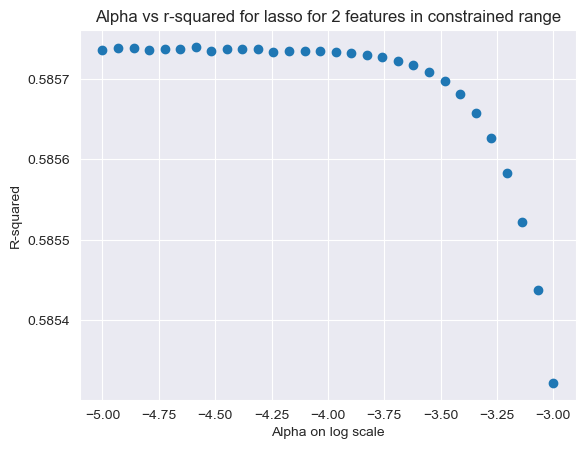

The optimal weights are [-0.3089 -0.5648]


In [27]:
lasso_range=np.logspace(start=-5,stop=-3,num=30) #2 features, further optimizing alpha in constrained range
rsq_lasso=[]
lasso_matrices=[]
biases=[]
for alpha in lasso_range:
  model=Lasso(alpha=alpha,max_iter=1000,tol=.01)
  cv=cross_validate(estimator=model,X=xtr2,y=yftr,scoring='r2',return_estimator=True)
  rsq=np.mean(cv['test_score'])
  rsq_lasso.append(rsq)
  coefficients = [estimator.coef_ for estimator in cv['estimator']]
  average_coefficients = np.mean(coefficients, axis=0)
  lasso_matrices.append(average_coefficients)
  bias = np.mean([estimator.intercept_ for estimator in cv['estimator']])
  biases.append(bias)


best_rsq=max(rsq_lasso)
best_rsq_arg=np.argmax(rsq_lasso)
best_alpha=lasso_range[best_rsq_arg]
best_bias=biases[best_rsq_arg]
best_weights=lasso_matrices[best_rsq_arg]
print(f'The best r-squared value using lasso is {round(best_rsq,4)}, which is when alpha = {round(best_alpha,6)}')
plt.scatter(np.log10(lasso_range),rsq_lasso)
plt.xlabel('Alpha on log scale')
plt.ylabel('R-squared')
plt.title('Alpha vs r-squared for lasso for 2 features in constrained range')
plt.show()
print(f'The optimal weights are {np.round(best_weights,4)}')

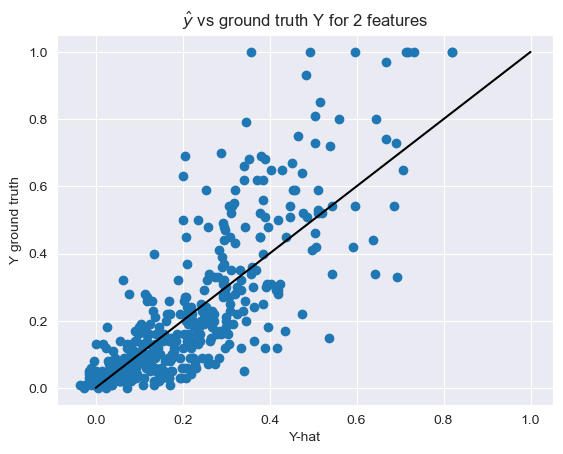

R-squared: 0.6387


In [28]:
model=Lasso(alpha=best_alpha,max_iter=1000,tol=.01)
model.fit(xtr2,yftr)
yhat_2=model.predict(xts2)

x_vals=np.linspace(0,1,100)
y_vals=x_vals


# Plot
plt.scatter(yhat_2, yfts)
plt.plot(x_vals,y_vals,color='black')
plt.xlabel("Y-hat")
plt.ylabel("Y ground truth")
plt.title(r'$\hat{y}$ vs ground truth Y for 2 features')
plt.show()

r2 = r2_score(yfts, yhat_2)
print(f"R-squared: {r2:.4f}")

In [ ]:
def linear_regression(X):
    return model.predict(X)